# CartPole DQN 실습 코드
DQN, Double DQN, Multistep DQN이 구현되어 있습니다.

## DQN 설명
Q-Learning은 (State, Action) 쌍을 Table 형태로 나타내야 하기 때문에 State가 이산적이지 않거나, 혹은 State의 경우의 수가 너무 많은 경우 Q-Learning을 적용하기 어렵습니다.

DQN은 위 문제를 해결하기 위해, Q-value를 Q-table이 아닌 신경망을 통해 근사합니다.

Q-table 대신 신경망을 사용함으로써, State 형식이 보다 자유로워졌지만, 학습 과정에서 여러 문제가 생깁니다.

DQN 논문에서는 이를 Experience Replay, Target Network를 통해 해결합니다.


본 실습에서는,

1. Neural Net 구현 (필수)
1. Experience Replay 구현 (필수)
    - N-step Learning 구현 (선택) 
1. DQN Interaction, Training Loop 구현 (필수)
1. Double DQN 구현 (필수)

을 진행할 예정입니다.

### PPT의 수도코드에 달린 줄번호는,
"줄번호"  (쌍따옴표를 붙여서) 검색하시면 구현하셔야 하는 부분으로 검색됩니다. 

In [3]:
%matplotlib inline
import random
from collections import deque
from typing import List, Tuple, Dict

import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display

plt.ioff()

display = Display(visible=0, size=(400, 300))
display.start()

In [4]:
# Jupyter에서 GIF를 직접 보기 위한 코드입니다. 출처: http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html , 수정 이지훈
from matplotlib import animation
from IPython.display import display, HTML


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(HTML(anim.to_jshtml()))

## 환경 확인
Cartpole 환경의 기본적인 정보를 확인해봅니다.

In [5]:
env = gym.make("CartPole-v0")

Observation은 4개의 Float로 주어집니다.

In [6]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

Action은 왼쪽, 오른쪽 2개가 있고, 정수 0 또는 1로 표현합니다.

In [7]:
env.action_space, env.action_space.sample()  # 샘플 시 0 또는 1

(Discrete(2), 0)

Observation을 직접 확인해봅니다.

In [8]:
observation, done = env.reset(), False
observation

array([-0.00996688,  0.01185695,  0.04275951, -0.00437867])

## Replay Memory 구현
Numpy의 Array를 이용해 Circular Buffer로 구현하거나, Python에서 제공되는 Deque로 구현하시면 됩니다.

정답 코드에는 Circular Buffer로 구현되어 있습니다.

In [9]:
# "1"
class ReplayMemory:
    def __init__(
        self, 
        observation_shape: tuple = (),
        action_shape: tuple = (),
        buffer_size: int = 50000,
        num_steps: int = 1,
    ):
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.buffer_size = buffer_size
        self.num_steps = num_steps
        
        # Transition 저장에 필요한 버퍼, 변수들을 선언해줍니다.
        ############### 여기부터 작성 ##################
        
        
        ############### 여기까지 작성 ##################
    
    
    def write(self, state, action, reward, next_state, done):
        ############### 여기부터 작성 ##################
        pass
        
        ############### 여기까지 작성 ##################
    
    
    # 버퍼에서 Uniform Random으로 Transition들을 뽑습니다.
    # State, Action, Reward, Next_State, Done의 Batch를 각각 Numpy Array로 반환해주세요.
    def sample(self, num_samples: int = 1) -> Tuple[np.ndarray]:
        ############### 여기부터 작성 ##################
        pass
        
        ############### 여기까지 작성 ##################


## NN 구현
단순한 MLP를 이용합니다. DQN에서는 Observation을 입력받아, Q-value를 출력합니다.

In [ ]:
# "2" "3"
class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
    
    
    def forward(self, x):
        pass

## DQN 학습 코드
Target Network와 Epsilon-Greedy를 통해 학습하는 DQN의 메인 로직 구현입니다.

In [ ]:
class DQNTrainer:
    def __init__(
        self,
        env: gym.Env,
        use_target: bool = True,
        optim_cls: type = torch.optim.Adam,
        optim_kwargs: dict = {'lr': 0.0005},
        loss_fn: nn.modules.loss = torch.nn.SmoothL1Loss(),
        eps_start: float = 0.3,
        eps_end: float = 0.01,
        eps_decay: float = 0.9995,  
        discount_rate: float = 0.98,
        n_steps: int = 1,
        double: bool = False,
        buffer_size: int = 50000,
        batch_size: int = 128,
        learning_starts: int = 512,
        train_freq: int = 1,
        target_update_freq: int = 2048,
        device="cuda"
    ):
        self.env = env
        self.use_target = use_target
        self.loss_fn = loss_fn
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.discount_rate = discount_rate
        self.n_steps = n_steps
        self.double = double
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.learning_starts = learning_starts
        self.train_freq = train_freq
        self.target_update_freq = target_update_freq
        self.device = device
        
        # 학습 과정 기록, 출력을 위한 변수들입니다.
        self.steps = 0
        self.episodes = 0
        
        self.alpha = 0.97
        self.reward_ema = 0.0
        self.episode_reward_ema = 0.0
        self.episode_length_ema = 0.0
        
        ############### 여기부터 작성 ##################
        
        # "1". Initialize replay memory D to capacity N
        self.replay_memory = None  # 작성해주세요!
        
        # "2". Initialize action-value function Q with random weights θ
        self.online_net = None  # 작성해주세요!
        
        # "3". Initialize target action-value function Q_hat with weights θ^- = θ
        self.target_net = None  # 작성해주세요!
        
         ############### 여기까지 작성 ##################
        
        self.optimizer = optim_cls(self.online_net.parameters(), **optim_kwargs)
        
    
    # Exponential decay to epsilon
    def update_epsilon(self):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_end)
    
    
    # Copy Online net's parameters to Target network
    def update_target(self):
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        
    def train(self, num_train_steps: int):
        begin_steps = self.steps
        
        episode_rewards = []
        episode_lengths = []
        episode_steps = []
        
        # 원래 pseudocode에서는 episode 횟수로 루프하지만, 여기서는 실질적인 환경과의 Interaction 횟수인 Step 수를 기준으로 잡았습니다.
        # "4". For episode = 1, M do
        while self.steps - begin_steps < num_train_steps:
            # "5". Initialize sequence s_1 = {x_1} and preprocessed sequence φ_1 = φ(s_1)
            done, ob = False, env.reset()
            episode_reward = 0.0
            episode_length = 0
            
            ############### 여기부터 작성 ##################
            
            # 에피소드가 끝날 때 까지 루프
            # "6". For t = 1, T do
            while not done:
                # Epsilon-Greedy로 Action 추출
                epsilon = self.epsilon
                self.update_epsilon()
                
                # "7". With probability ε select a random action a_t
                if None:
                    pass  # 작성해주세요!
                # "8". otherwise select a_t = argmax_a Q(φ(s_t), a; θ)
                else:
                    pass  # 작성해주세요!
                
                # "9". Execute action a_t in emulator and observe reward r_t and image x_(t+1)
                next_ob, reward, done, info = env.step(action)
                
                # "10". Store transition (φ_t, a_t, r_t, φ_(t + 1)) in D.                             지금은 φ_t와 x_t는 observation과 같습니다. Done도 함께 저장해야 합니다.
                self.replay_memory.write(ob, action, reward, next_ob, done)
                ob = next_ob  # 직전 State를 다시 저장해줍니다.
                
                # 정해진 step 수 마다 Online Network를 학습시킵니다.
                if self.steps > self.learning_starts and self.steps % self.train_freq == 0:
                    self.update_network()
                
                # 정해진 step 수 마다 Target Network를 업데이트합니다.
                # "14". Every C steps reset Q_hat = Q
                self.target_update_freq
                pass  # 작성해주세요!
            
            ############### 여기까지 작성 ##################
                
                self.steps += 1
                episode_reward += reward
                episode_length += 1
                self.reward_ema = self.alpha * self.reward_ema + (1.0 - self.alpha) * reward
                
            print(f"\r Steps: {self.steps - begin_steps}/{num_train_steps}, Epsilon: {epsilon:.4f},"\
                    + f" Avg. Reward: {self.reward_ema:.2f}, Avg. Epi. Reward: {self.episode_reward_ema:.2f},"\
                    + f" Last Epi. Reward: {episode_reward}     ", end="", flush=True)
            
            self.episode_reward_ema = self.alpha * self.episode_reward_ema + (1.0 - self.alpha) * episode_reward
            self.episode_length_ema = self.alpha * self.episode_length_ema + (1.0 - self.alpha) * episode_length
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            episode_steps.append(self.steps)
            
        return episode_rewards, episode_lengths, episode_steps
    
    
    def update_network(self):
        self.optimizer.zero_grad()
        
        # Experience Replay에서 랜덤하게 Experiences를 뽑아옵니다.
        # "11". Sample random minibatch of transitions (φ_j, a_j, r_j, φ_(j + 1)) from D
        state, action, reward, next_state, done = self.replay_memory.sample(self.batch_size)
        
        state = torch.FloatTensor(state).to(self.device)
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)
        
        ############### 여기부터 작성 ##################
        
        # "12". set y_j = {...}
        with torch.no_grad():
            if not self.double:  # "12"-1. y_j = r_j + γ * max_a' Q_hat(φ_j, a'; θ^-)
                pass  # 작성해주세요!
            
            else:  # "Double". y_j = r_j + γ Q_hat(φ_j, argmax_a Q(φ_j, a; θ); θ^-) 
                pass  # 작성해주세요!
        
        # "13". Perform a gradient step on (y_j - Q(φ_j, a_j; θ))^2 with respect to the network parmeters θ.
        pred = None  # 작성해주세요!  참고: https://pytorch.org/docs/stable/generated/torch.gather.html
        
        ############### 여기까지 작성 ##################
        
        loss = self.loss_fn(pred, target)
        loss.backward()
        
        for param in self.online_net.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()
    
    
    def predict(self, ob):
        return torch.argmax(self.online_net.forward(torch.Tensor(ob).to(self.device))).item()
        
        

### DQN 학습 진행

In [10]:
%%time
env = gym.make("CartPole-v1")
plain_trainer = DQNTrainer(env, device="cuda", double=False, n_steps=1)
plain_result = plain_trainer.train(50000)

 Steps: 50068/50000, Epsilon: 0.0100, Avg. Reward: 1.00, Avg. Epi. Reward: 146.10, Last Epi. Reward: 127.0     Wall time: 2min 27s


In [11]:
%%time
env = gym.make("CartPole-v1")
double_trainer = DQNTrainer(env, device="cuda", double=True, n_steps=1)
double_result = double_trainer.train(50000)

 Steps: 50003/50000, Epsilon: 0.0100, Avg. Reward: 1.00, Avg. Epi. Reward: 86.21, Last Epi. Reward: 40.0       Wall time: 2min 33s


In [12]:
%%time
env = gym.make("CartPole-v1")
dbl_multi_trainer = DQNTrainer(env, device="cuda", double=True, n_steps=8)
dbl_multi_result = dbl_multi_trainer.train(50000)

 Steps: 50141/50000, Epsilon: 0.0100, Avg. Reward: 1.00, Avg. Epi. Reward: 445.83, Last Epi. Reward: 500.0     Wall time: 2min 32s


In [13]:
%%time
env = gym.make("CartPole-v1")
no_replay_trainer = DQNTrainer(env, device="cuda", batch_size=128, buffer_size=128, double=False, n_steps=1)
no_replay_result = no_replay_trainer.train(50000)

 Steps: 50278/50000, Epsilon: 0.0100, Avg. Reward: 1.00, Avg. Epi. Reward: 129.68, Last Epi. Reward: 500.0     Wall time: 2min 5s


In [14]:
%%time
env = gym.make("CartPole-v1")
no_target_trainer = DQNTrainer(env, device="cuda", use_target=False, double=False, n_steps=1)
no_target_result = no_target_trainer.train(50000)

 Steps: 50008/50000, Epsilon: 0.0100, Avg. Reward: 1.00, Avg. Epi. Reward: 9.36, Last Epi. Reward: 10.0     Wall time: 2min 34s


# 학습 결과 시각화
학습 과정에 대한 그래프와, 학습이 완료된 에이전트의 능력을 동영상으로 확인해봅니다.

In [1]:
def plot_with_exponential_averaging(x, y, label, alpha):
    y_ema = [y[0]] 
    for y_i in y[1:]:
        y_ema.append(y_ema[-1] * alpha + y_i * (1 - alpha))
    
    p = plt.plot(x, y_ema, label=label)
    
    plt.plot(x, y, color=p[0].get_color(), alpha=0.2)
    

def plot_dqn_train_result(result, label="", alpha=0.95):
    plot_with_exponential_averaging(result[2], result[0], label, alpha)

### 학습 과정

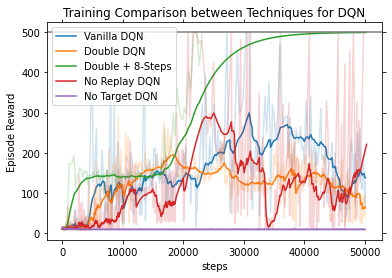

In [25]:
plt.cla()
plot_dqn_train_result(plain_result, label="Vanilla DQN", alpha=0.9)
plot_dqn_train_result(double_result, label="Double DQN", alpha=0.9)
plot_dqn_train_result(dbl_multi_result, label="Double + 8-Steps", alpha=0.9)
plot_dqn_train_result(no_replay_result, label="No Replay DQN", alpha=0.9)
plot_dqn_train_result(no_target_result, label="No Target DQN", alpha=0.9)

plt.axhline(y=500, color='grey', linestyle='-')
plt.xlabel("steps")
plt.ylabel("Episode Reward")

plt.legend()
plt.title("Training Comparison between Techniques for DQN")
plt.show()

### 학습 결과

In [26]:
env = gym.make('CartPole-v0')
frames = []

ob, done = env.reset(), False
while not done:
    frames.append(env.render(mode = 'rgb_array'))
    action = dbl_multi_trainer.predict(ob)
    ob, reward, done, info = env.step(action)
env.close()
display_frames_as_gif(frames)

# Playground
마음껏 파라미터, 코드 등을 수정해보세요!